In [2]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import xarray as xr
import openpyxl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


In [3]:
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable1='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT']

In [4]:
sourceData1='/bettik/PROJECTS/pr-regional-climate/santolam/MARout/GRa/spin2/work/monthly/'
dsM_SF= xr.open_dataset(sourceData1+'RF_mon_MARv3.14_ER5_spin2_GRa_2000-2023.nc')['RF']
dsM_RF= xr.open_dataset(sourceData1+'SF_mon_MARv3.14_ER5_spin2_GRa_2000-2023.nc')['SF']

dsMP=dsM_RF+dsM_SF
dsMP = dsMP.rename({'TIME': 'time'})

In [5]:
## Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [6]:
#Gra Mera 5km
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT'][:,1,:,:] ## montlhy mean

In [7]:

lon_Khare=86.8776142768303

lat_Khare=27.74424682282522
elev_Khare=4888
##Find the pixel of MAR corresponding to station
target_lon = lon_Khare
target_lat = lat_Khare
lon=ds_grM.LON
lat=ds_grM.LAT

In [8]:
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

<xarray.DataArray (y: 116, x: 164)> Size: 76kB
array([[5.270343 , 5.2231975, 5.176104 , ..., 3.6185825, 3.6622922,
        3.706156 ],
       [5.256296 , 5.2090063, 5.1617656, ..., 3.5971217, 3.6410923,
        3.6852484],
       [5.242597 , 5.195149 , 5.1477613, ..., 3.5760908, 3.620341 ,
        3.664761 ],
       ...,
       [6.064623 , 6.0212607, 5.978028 , ..., 4.6067305, 4.6431766,
        4.679899 ],
       [6.090233 , 6.0470266, 6.0039673, ..., 4.6394615, 4.675679 ,
        4.712169 ],
       [6.116065 , 6.073031 , 6.03012  , ..., 4.6724114, 4.7083845,
        4.7446556]], shape=(116, 164), dtype=float32)
Coordinates:
  * x        (x) float32 656B -495.0 -490.0 -485.0 -480.0 ... 310.0 315.0 320.0
  * y        (y) float32 464B -195.0 -190.0 -185.0 -180.0 ... 370.0 375.0 380.0


In [9]:
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_sta=dsM[0:, i, j-1]
dsM_sta_precip=dsMP[0:, i, j-1]




dsM_sta_new2= dsM_sta.rename({'TIME': 'time'})
#units=dsM.units
dsM_sta_new= dsM_sta_new2.where(dsM_sta_new2.values <= 70)
#dsM_sta_new.values


In [10]:
#Evaluer la différence de hauteur entre la station et le niveau 1 de la grille MAR considérée
SH_sta=elev_Khare
value = ds_grM['SH'].isel(y=j-1, x=i)
diff=SH_sta-value.values
value.values, diff

(array(5064.1274, dtype=float32), np.float32(-176.12744))

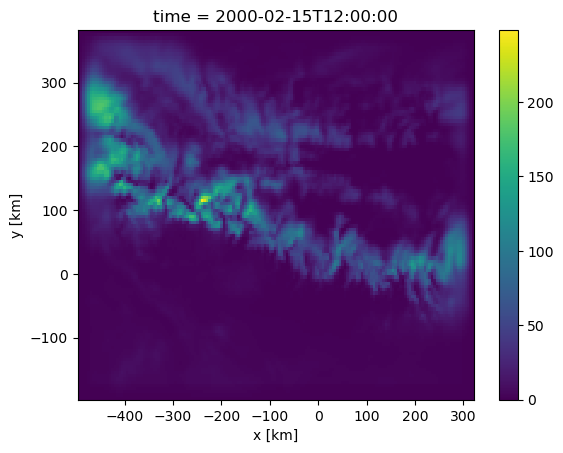

In [11]:
dsMP[1,:,:].plot()

In [12]:
####
## Opening station data
####

In [13]:
path ="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_precip/Precipitation_Khare_corrected_Nov2016_Nov2023_final.xlsx"
xl_data=pd.ExcelFile(path)
print(xl_data)

In [14]:
dfs = {sheet_name: xl_data.parse(sheet_name) 
       for sheet_name in xl_data.sheet_names}
DataKhare16_23=dfs['Precip_data_Nov16_Nov23']

In [15]:
NameVarsPP16_23=['Time','Tair','u','RH','WMOphase','RRhourly','RRcumul']
UnitVarsPP16_23=['data/hour','(°C)','(ms-1)','(%)','mm','mm']

In [16]:
dfileP16_23= pd.DataFrame(data=DataKhare16_23.loc[10:])

In [17]:
dfP16_23=pd.DataFrame(dfileP16_23.values, columns=NameVarsPP16_23)
Tair_ar=[float(i) for i in dfP16_23.Tair.values]  
RRcumul_ar=[float(i) for i in dfP16_23.RRcumul.values] 
RR=[float(i) for i in dfP16_23.RRhourly.values] 



In [18]:
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = dfP16_23.Time.values[0], dfP16_23.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    print("taille var:",len(Var_ar))  
    print("taille t:",len(time))    
    return ds 

T=NewTime('Tair',Tair_ar,'30min')
RRcumul=NewTime('RRcumul',RRcumul_ar,'30min')
RR=NewTime('RRhourly',RR,'30min')

taille var: 122305
taille t: 122305
taille var: 122305
taille t: 122305
taille var: 122305
taille t: 122305


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20,16))
ax1.plot(T.time, T['Tair'].values)
ax2.plot(RRcumul.time, RRcumul['RRcumul'].values)

In [19]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [20]:
daily_meanRR=RR.resample(time='D').sum()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanRR=daily_meanRR.resample(time='ME').sum()             # chaque variable ici défini est un xarray.Dataset
yearly_meanRR=monthly_meanRR.resample(time='YE').sum()


daily_meanT=T.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanT=daily_meanT.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanT=monthly_meanT.resample(time='YE').mean()

<BarContainer object of 85 artists>

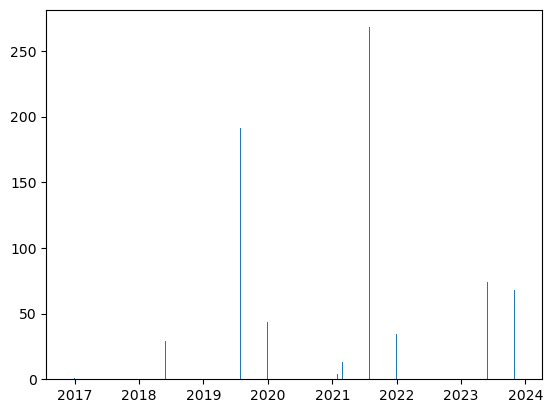

In [21]:
plt.bar(monthly_meanRR.time,monthly_meanRR.RRhourly)

In [22]:
# Get the time coordinates CORRIGER DIFF ENTRE MAR ET STATION
time1 = monthly_meanT['time']# début 
time2 = dsM_sta_new['time'] # début 
time3=dsM_sta_precip['time']

start=time1[0] 
end=time2[-1]

In [23]:
ts_sta=monthly_meanT.sel(time=slice(start,end))

ts_MAR=dsM_sta_new.sel(time=slice(start,end))

In [24]:
Pr_sta=monthly_meanRR.sel(time=slice(start,end))
Pr_MAR=dsM_sta_precip.sel(time=slice(start,end))


<BarContainer object of 288 artists>

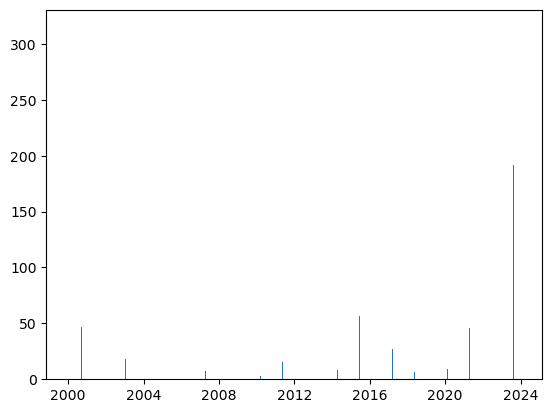

In [25]:
plt.bar(dsM_sta_precip.time,dsM_sta_precip.values)

In [26]:
Pr_MAR

<xarray.DataArray (time: 85)> Size: 340B
array([  5.3760524 ,  15.162047  ,  12.694339  ,  27.186684  ,
        10.889452  ,  54.977875  ,  30.579815  , 314.86368   ,
       137.26581   ,  30.231194  ,   1.9501246 ,   6.1370916 ,
         5.56058   ,   5.478899  ,   7.3526382 ,   7.316601  ,
         5.103422  ,   6.653863  ,  27.772312  , 185.79898   ,
       268.04248   ,  62.800423  ,   0.83930236,   1.3778626 ,
         6.7848005 ,  52.62052   ,  66.22345   ,  15.808338  ,
        19.418896  ,   6.495266  ,  16.323057  , 101.26275   ,
       178.95319   ,  44.766617  ,   3.5040622 ,   3.2754464 ,
        21.95254   ,  54.407623  ,   9.171574  ,  28.651976  ,
        31.681992  ,  19.572577  ,  88.08904   , 134.25212   ,
        69.61365   ,  50.979454  ,   0.80324054,  10.449702  ,
         1.4891497 ,   6.313525  ,   7.855215  ,   9.110443  ,
        46.3118    ,  77.06139   , 133.0935    , 119.84165   ,
       122.322266  ,  90.01773   ,  21.288004  ,   0.36436978,
        32.46198   ,  14.13237   ,  11.773882  ,   0.46056527,
         2.2242663 ,  43.92934   ,  18.644459  ,  84.333595  ,
       163.04231   , 108.01207   ,  84.54295   ,   1.1887739 ,
         0.3833498 ,   5.537981  ,   1.5185776 ,  18.59379   ,
        40.324944  ,  16.526041  ,  28.554415  , 145.87285   ,
       191.27881   ,  54.98035   ,  15.1072    ,   7.5606627 ,
         6.1608524 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 680B 2016-12-16T12:00:00 ... 2023-12-16T12...
    X        float32 4B -300.0
    Y        float32 4B 300.0

In [27]:
# Precip sta classic climatic variables 
RR_premon= seasonsdata(Pr_sta, 'MAM').resample(time='YE').mean()
RR_mon =seasonsdata(Pr_sta, 'JJAS').resample(time='YE').mean()
RR_postmon=seasonsdata(Pr_sta, 'ON').resample(time='YE').mean()
RR_hiver=seasonsdata(Pr_sta, 'DJF').resample(time='YE').mean()

In [28]:

#T MAR classic climate variables
PrMAR_monthly_cycle=Pr_MAR.groupby('time.month').mean()

#dsM_sta_new


PrMAR_premon = seasonsdata(Pr_MAR, 'MAM').resample(time='YE').sum()

PrMAR_mon = seasonsdata(Pr_MAR, 'JJAS').resample(time='YE').sum()

PrMAR_postmon =  seasonsdata(Pr_MAR, 'ON').resample(time='YE').sum()

PrMAR_hiver  = seasonsdata(Pr_MAR, 'DJF').resample(time='YE').sum()


#Time series annual data MAR 
Timeseries_PrMAR_premon = seasonsdata(Pr_MAR, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_PrMAR_mon = seasonsdata(Pr_MAR, 'JJAS').resample(time='YE').mean()
Timeseries_PrMAR_postmon =  seasonsdata(Pr_MAR, 'ON').resample(time='YE').mean()
Timeseries_PrMAR_hiver  = seasonsdata(Pr_MAR, 'DJF').resample(time='YE').mean()



Text(0.5, 0.98, 'Seasonsal Comparaisons between MAR model and Khare seasonal mean Precipitations')

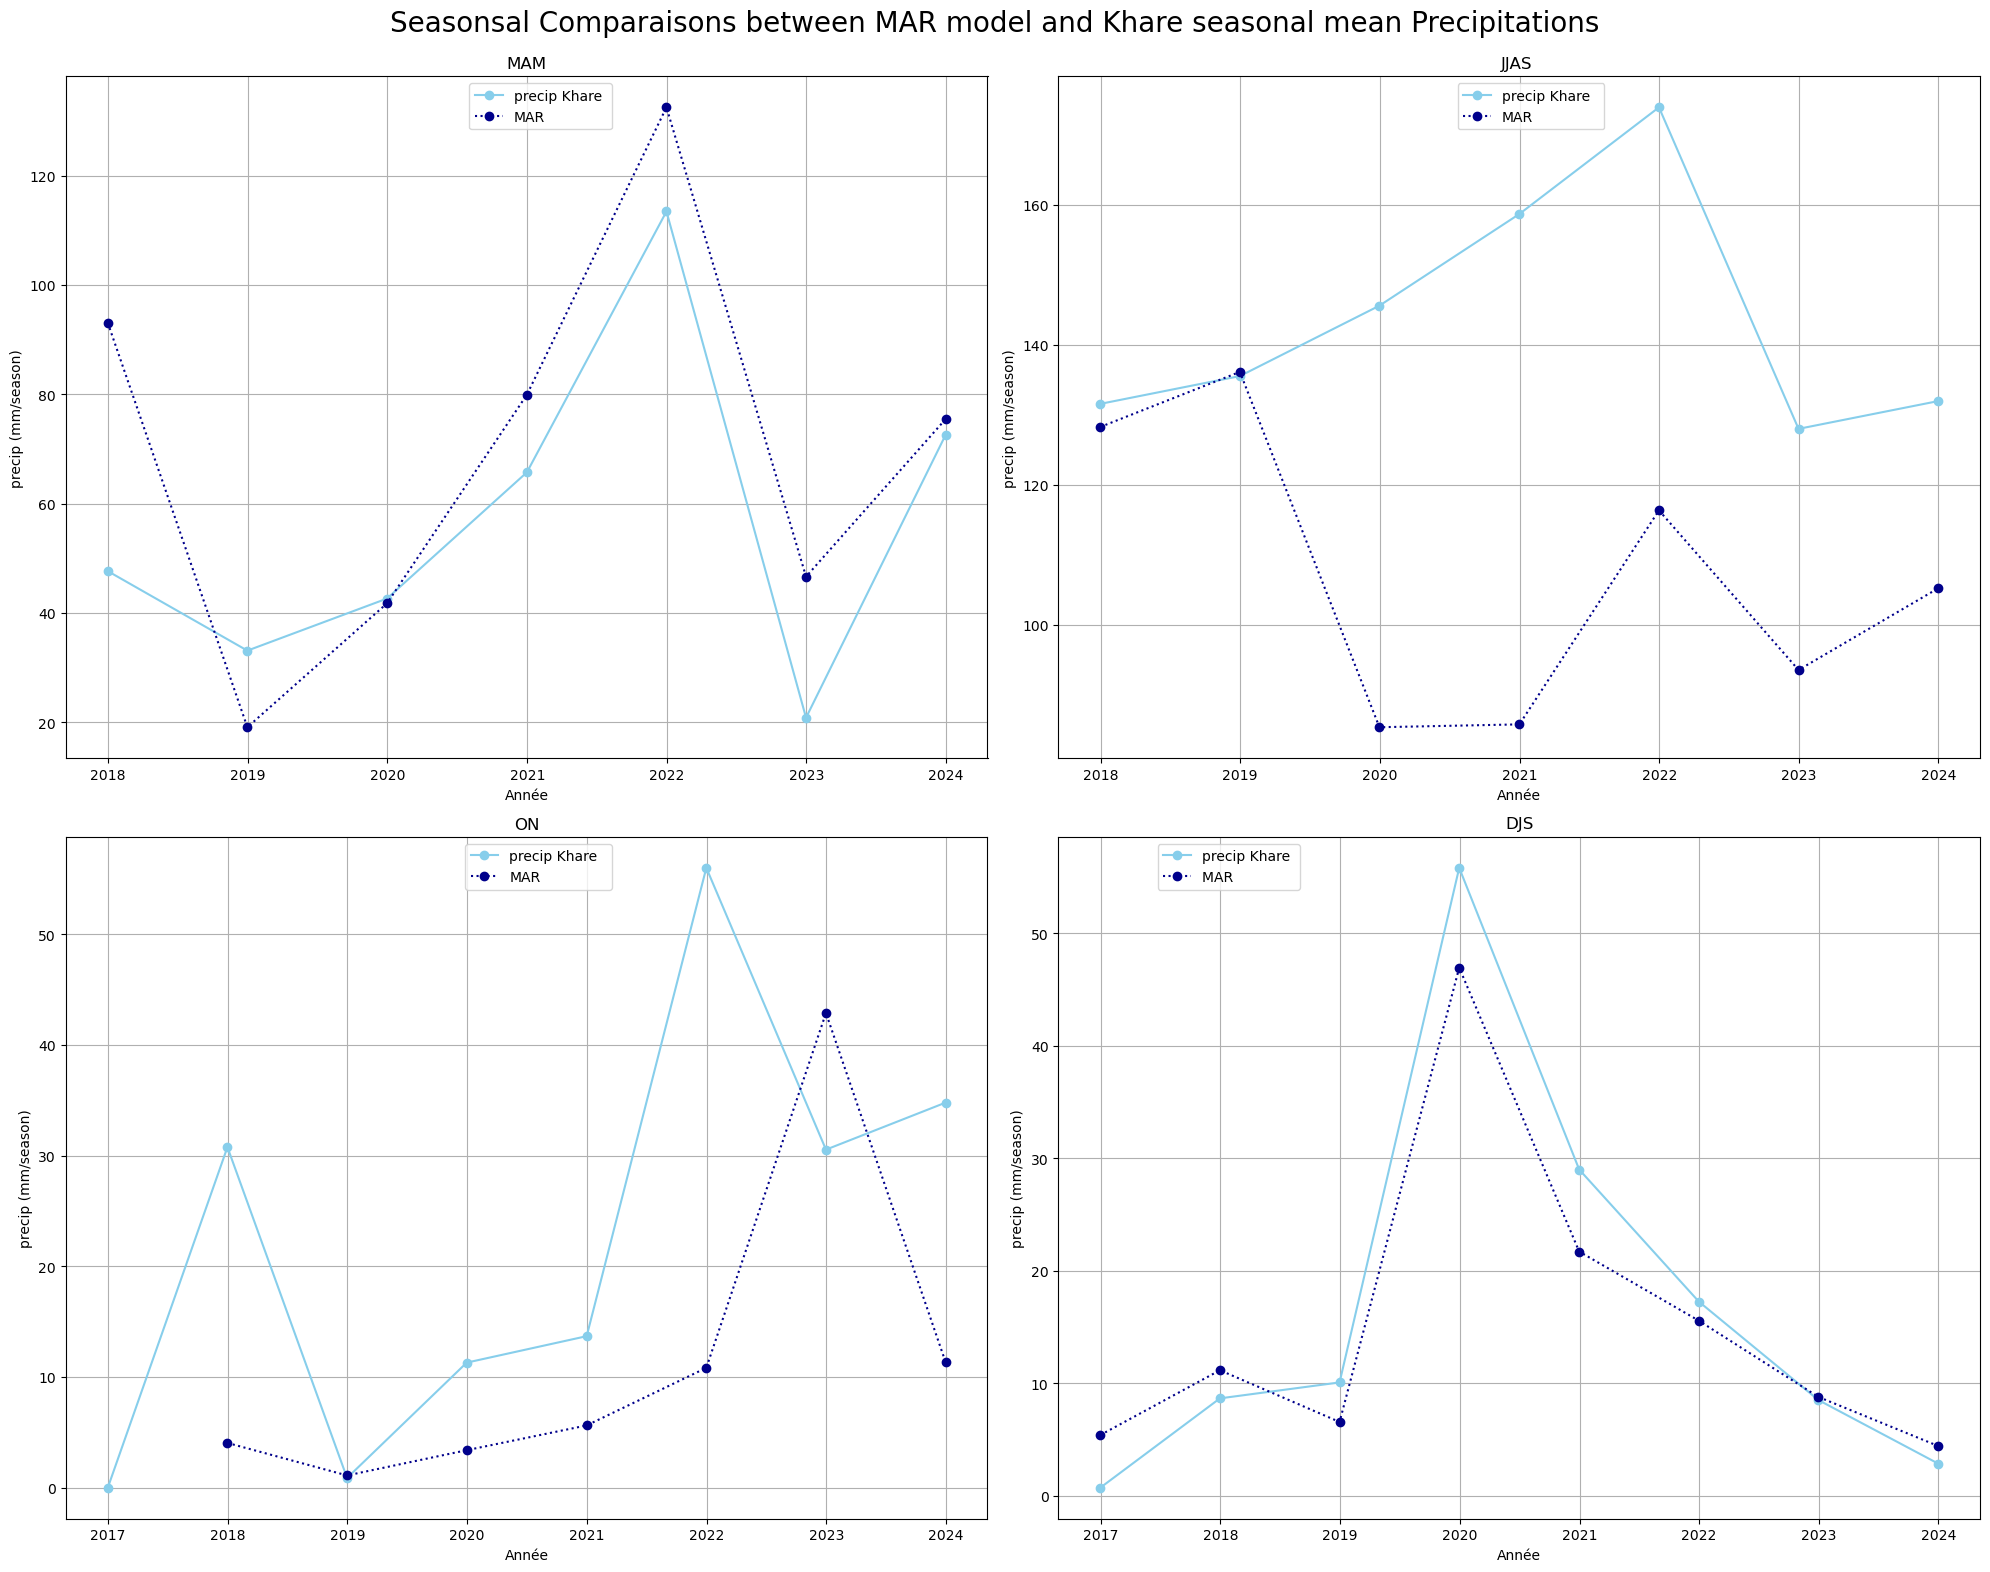

In [29]:
fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(RR_premon.time, RR_premon['RRhourly'].values, linestyle='-',color='skyblue', marker= 'o', label='precip Khare ')
ax1.plot(PrMAR_premon.time, PrMAR_premon.values, linestyle=':',color='darkblue', marker= 'o', label='MAR')

ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Année')
ax1.set_ylabel('precip (mm/season)')
ax1.grid()

ax2.plot(RR_mon.time, RR_mon['RRhourly'].values,linestyle='-', marker= 'o',color='skyblue', label='precip Khare  ')
ax2.plot(Timeseries_PrMAR_mon.time, Timeseries_PrMAR_mon.values, linestyle=':',color='darkblue', marker= 'o', label='MAR')

ax2.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax2.set_title('JJAS ')
ax2.set_xlabel('Année')
ax2.set_ylabel('precip (mm/season)')
ax2.grid()

ax3.plot(RR_postmon.time, RR_postmon['RRhourly'].values,linestyle='-', marker= 'o',color='skyblue', label='precip Khare  ')
ax3.plot(Timeseries_PrMAR_postmon.time, Timeseries_PrMAR_postmon.values,color='darkblue', linestyle=':', marker= 'o', label='MAR')

ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Année')
ax3.set_ylabel('precip (mm/season)')
ax3.grid()

ax4.plot(Timeseries_PrMAR_hiver.time, RR_hiver['RRhourly'].values,linestyle='-', marker= 'o', color='skyblue',label='precip Khare ')
ax4.plot(Timeseries_PrMAR_hiver.time, Timeseries_PrMAR_hiver.values, linestyle=':',color='darkblue', marker= 'o', label='MAR ')

ax4.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5))
ax4.set_title('DJS')
ax4.set_xlabel('Année')
ax4.set_ylabel('precip (mm/season)')
ax4.grid()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons between MAR model and Khare seasonal mean Precipitations',fontsize=20)

plt.plot(RR_premon.time, RR_premon['RRhourly'].values, linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')

plt.plot(RR_mon.time, RR_mon['RRhourly'].values,linestyle=':', marker= 'o', label=' précipitations moyennes saisonnières')


plt.plot(RR_postmon.time, RR_postmon['RRhourly'].values,linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')


plt.plot(RR_hiver.time, RR_hiver['RRhourly'].values,linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
plt.grid(True)

In [30]:
PrMAR_monthly_cycle

<xarray.DataArray (month: 12)> Size: 48B
array([ 21.950424 ,  16.655668 ,  15.304056 ,  22.279253 ,  32.173763 ,
        49.008087 , 155.1751   , 161.50266  ,  63.11255  ,  18.290697 ,
         4.3362727,  10.021163 ], dtype=float32)
Coordinates:
    X        float32 4B -300.0
    Y        float32 4B 300.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

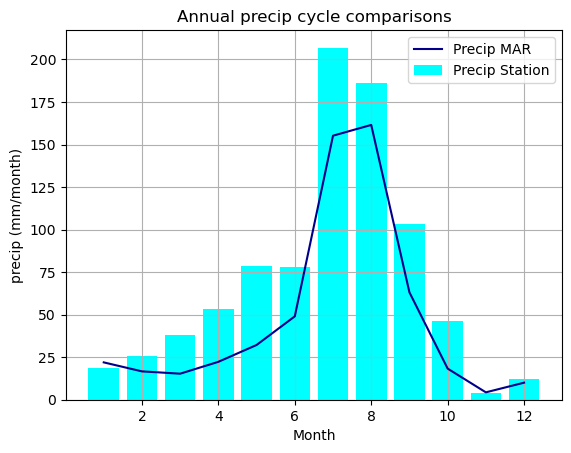

In [31]:
#Annual cycle 
#daily_meanRR2=RR.resample(time='D').sum()  
Précip_yearly_cycle=monthly_meanRR.groupby('time.month').mean()


plt.bar(Précip_yearly_cycle.month,Précip_yearly_cycle.RRhourly,
        color='cyan',linestyle='-',label='Precip Station')
plt.plot(PrMAR_monthly_cycle.month,PrMAR_monthly_cycle.values,
         color='darkblue',linestyle='-',label='Precip MAR')
plt.legend()    
plt.title('Annual precip cycle comparisons')
plt.xlabel('Month')
plt.ylabel('precip (mm/month)')

plt.grid(True)

In [32]:
#T sta classic climatic variables 

ts_sta=monthly_meanT

Tsta_monthly_cycle=ts_sta.groupby('time.month').mean()
Tsta_premon = seasonsdata(ts_sta, 'MAM').groupby('time.month').mean()

Tsta_mon = seasonsdata(ts_sta, 'JJAS').groupby('time.month').mean()

Tsta_postmon =  seasonsdata(ts_sta, 'ON').groupby('time.month').mean()

Tsta_hiver  = seasonsdata(ts_sta, 'DJF').groupby('time.month').mean()

#Time series annual data sta
Timeseries_Tsta_premon = seasonsdata(ts_sta, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_Tsta_mon = seasonsdata(ts_sta, 'JJAS').resample(time='YE').mean()
Timeseries_Tsta_postmon =  seasonsdata(ts_sta, 'ON').resample(time='YE').mean()
Timeseries_Tsta_hiver  = seasonsdata(ts_sta, 'DJF').resample(time='YE').mean()

In [33]:
#T MAR classic climate variables
TMAR_monthly_cycle=dsM_sta_new.groupby('time.month').mean()

#dsM_sta_new


TMAR_premon = seasonsdata(ts_MAR, 'MAM').groupby('time.month').mean()

TMAR_mon = seasonsdata(ts_MAR, 'JJAS').groupby('time.month').mean()

TMAR_postmon =  seasonsdata(ts_MAR, 'ON').groupby('time.month').mean()

TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').groupby('time.month').mean()


#Time series annual data MAR 
Timeseries_TMAR_premon = seasonsdata(ts_MAR, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_TMAR_mon = seasonsdata(ts_MAR, 'JJAS').resample(time='YE').mean()
Timeseries_TMAR_postmon =  seasonsdata(ts_MAR, 'ON').resample(time='YE').mean()
Timeseries_TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').resample(time='YE').mean()





-176.12744


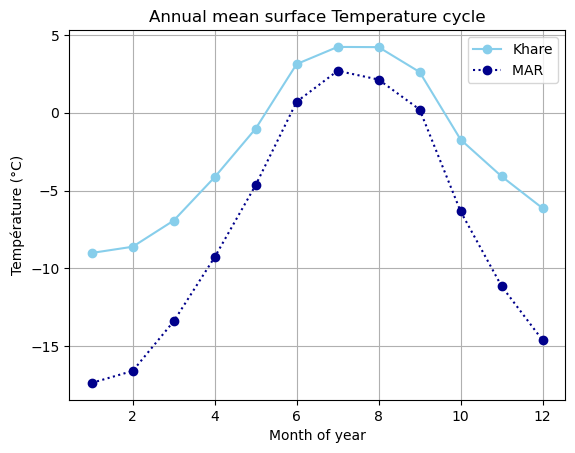

In [34]:
#Monthly cycle

plt.plot(Tsta_monthly_cycle.month,Tsta_monthly_cycle.Tair,
    color='skyblue',linestyle='-', marker= 'o',label='Khare')

plt.plot(TMAR_monthly_cycle.month,TMAR_monthly_cycle.values,
         color='darkblue',linestyle=':', marker= 'o',label='MAR ')
plt.legend()
plt.title('Annual mean surface Temperature cycle')
plt.xlabel('Month of year')
plt.ylabel('Température (°C)')

plt.grid(True)
print(diff)

Text(0.5, 0.98, 'Seasonsal Comparaisons between MAR model and Khare seasonal mean Temperatures')

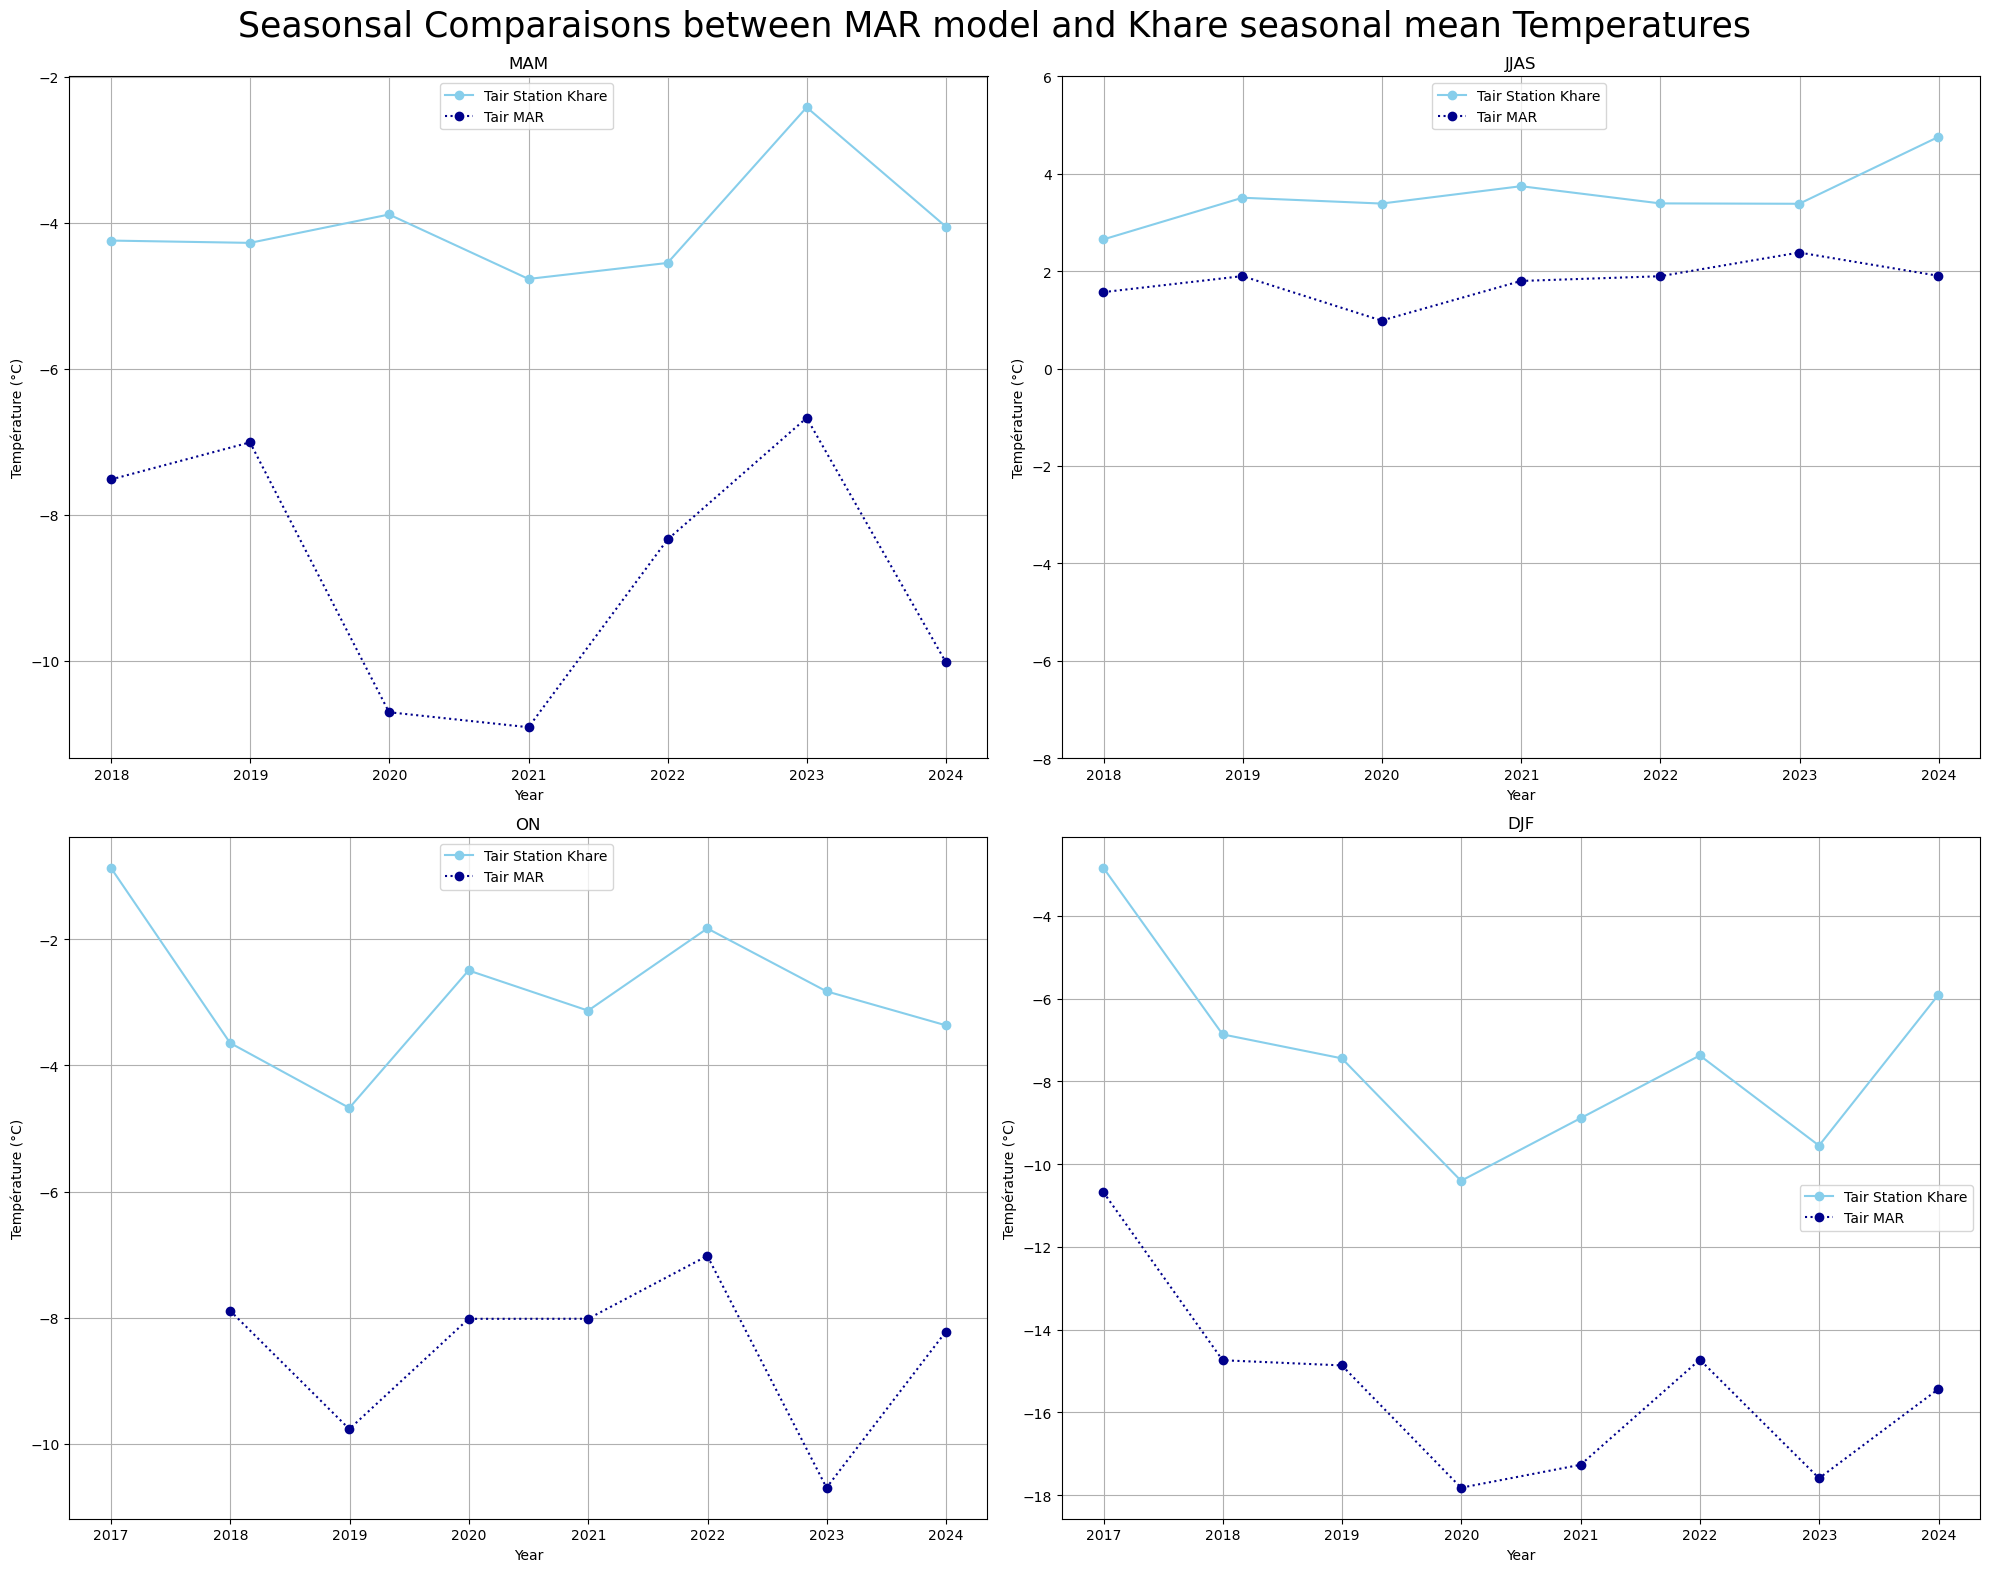

In [35]:
#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Timeseries_Tsta_premon.time, Timeseries_Tsta_premon['Tair'].values,color='skyblue', linestyle='-', marker= 'o', label='Tair Station Khare')
ax1.plot(Timeseries_TMAR_premon.time, Timeseries_TMAR_premon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')


ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Year')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Timeseries_Tsta_mon.time, Timeseries_Tsta_mon['Tair'].values,color='skyblue', linestyle='-',marker= 'o', label='Tair Station Khare')
ax2.plot(Timeseries_TMAR_mon.time, Timeseries_TMAR_mon.values, linestyle=':',color='darkblue', marker= 'o', label='Tair MAR')



ax2.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax2.set_title('JJAS')
ax2.set_xlabel('Year')
ax2.set_ylabel('Température (°C)')
ax2.set_yticks(np.arange(-8, 8, 2))  

ax2.grid()

ax3.plot(Timeseries_Tsta_postmon.time, Timeseries_Tsta_postmon['Tair'].values,color='skyblue', linestyle='-', marker= 'o', label='Tair Station Khare')
ax3.plot(Timeseries_TMAR_postmon.time, Timeseries_TMAR_postmon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')


ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Year')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Timeseries_Tsta_hiver.time, Timeseries_Tsta_hiver['Tair'].values, color='skyblue',linestyle='-', marker= 'o', label='Tair Station Khare')
ax4.plot(Timeseries_TMAR_hiver.time, Timeseries_TMAR_hiver.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax4.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Year')
ax4.set_ylabel('Température (°C)')
ax4.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons between MAR model and Khare seasonal mean Temperatures',fontsize=25)